<a href="https://colab.research.google.com/github/AI-ClassWork/Tensorflow_Fundamentals/blob/main/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow part 2: Fine Tuning.

In [13]:
# Check if we're using a GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Creating helper functions

In previous notebooks, we've created a bunch of helper functions. However, this is tedious. 

So,it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks(or elsewhere)

We've done this for some of the functions we've used previously here https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

In [14]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-03-17 14:14:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-03-17 14:14:57 (64.0 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [15]:
# Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves,unzip_data, walk_through_dir

**Note** If you're running this notebook in Google Collab, Colab will delete `helper_finctions.py` when it runs out.
You'll have to redownload it to use it

##Let's get some data

This time we're going to see if we can use the pretrained models using `tf.keras.applications` and apply them to our own problem (recognizing images of food).


In [16]:
# Get 10% of training data of 10 classes of Food101:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2022-03-17 14:14:57--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.188.48, 172.217.15.80, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.188.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   112MB/s    in 1.4s    

2022-03-17 14:14:58 (112 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [17]:
# Check out how many images and subdirectories are in our dataset

walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [18]:
# Create training and test directory paths
train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [19]:
# Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical",
                                                                           batch_size=32)
                              

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [20]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [21]:
#Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [22]:
#See an example of a batch of data
for images,labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[6.99081650e+01 6.19081612e+01 2.29081631e+01]
   [6.67142868e+01 5.77142830e+01 1.87142849e+01]
   [5.60459213e+01 4.64030647e+01 7.61734724e+00]
   ...
   [8.68727112e+01 7.88727112e+01 3.98727074e+01]
   [8.40051193e+01 8.00051193e+01 3.50051155e+01]
   [8.46172714e+01 8.06172714e+01 3.56172752e+01]]

  [[6.72142868e+01 5.82142868e+01 1.92142868e+01]
   [6.54897919e+01 5.64897957e+01 1.74897938e+01]
   [5.53979607e+01 4.57551041e+01 6.96938896e+00]
   ...
   [6.81125107e+01 5.89696732e+01 2.05665493e+01]
   [9.17805862e+01 8.47805862e+01 4.27805862e+01]
   [8.79540863e+01 8.09540863e+01 3.69540825e+01]]

  [[6.18469391e+01 5.12040825e+01 1.54183674e+01]
   [5.39693871e+01 4.33265305e+01 7.54081631e+00]
   [5.93418350e+01 4.81938782e+01 1.25765314e+01]
   ...
   [5.42856293e+01 4.39234543e+01 5.94888306e+00]
   [8.37603149e+01 7.41174622e+01 3.33317451e+01]
   [8.95713272e+01 7.99284668e+01 3.91427536e+01]]

  ...

  [[1.63852585e+02 1.62143448e+02 1.44924088e+02]
   [1

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

In [23]:
# 1. Create base model with tf.keras.applications
base_model=tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model ( the underlying pre=trained patterns aren't updated)
base_model.trainable=False

# 3. Create inputs into our model
inputs=tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using a model like ResNet50v2 you will need to normalize inputs(You don't have to in EfficientNet)
# x=tf.keras.layer.experimental.preprocessing.Rescaling(1/255.)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inpits through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate the modt important information, reduce number of computations)
x= tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs=tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0=tf.keras.Model(inputs,outputs)

# 9. Combile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. Fit the model and save its history
history_10_percent=model_0.fit(train_data_10_percent,
                               epochs=5,
                               steps_per_epoch=len(train_data_10_percent),
                               validation_data=test_data,
                               validation_steps=int(0.25*len(test_data)),
                               callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                      experiment_name="model_0_10_percent")])





Shape after passing inpits through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/model_0_10_percent/20220317-141510
Epoch 1/5
24/24 [==============================] - 93s 3s/step - loss: 1.8215 - accuracy: 0.4613 - val_loss: 1.2713 - val_accuracy: 0.7336
Epoch 2/5
24/24 [==============================] - 76s 3s/step - loss: 1.0953 - accuracy: 0.7667 - val_loss: 0.8730 - val_accuracy: 0.8240
Epoch 3/5
24/24 [==============================] - 74s 3s/step - loss: 0.8162 - accuracy: 0.8200 - val_loss: 0.6930 - val_accuracy: 0.8503
Epoch 4/5
24/24 [==============================] - 74s 3s/step - loss: 0.6540 - accuracy: 0.8440 - val_loss: 0.6219 - val_accuracy: 0.8470
Epoch 5/5
24/24 [==============================] - 76s 3s/step - loss: 0.5715 - accuracy: 0.8640 - val_loss: 0.5607 - val_accuracy: 0.8520


In [24]:
# Evaluate on the full test data
model_0.evaluate(test_data)

79/79 [==============================] - 114s 1s/step - loss: 0.5979 - accuracy: 0.8424


[0.5979278087615967, 0.8424000144004822]

In [25]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number,layer.name)

0 input_2
1 rescaling_1
2 normalization_1
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [26]:
#How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_1 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_1[0][0]']            
 )                              3)                                                   

In [27]:
# How about a summary of our whole model?
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


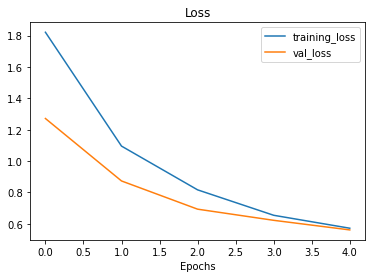

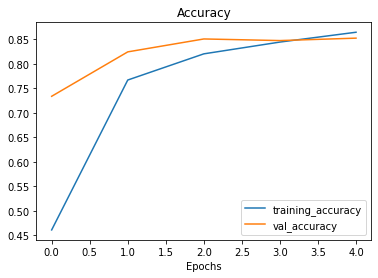

In [28]:
# Check out our model's training curves
plot_loss_curves(history_10_percent)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer..

We have a tensor after our model goes through `base_model` of shape (None,7,7,1280)..

But then when it passses through GlobalAvergaePooling2D, it turn into (None,1280)

Let's use a similar tensor of (1,4,4,3) and then pass it to GlobalAveragepooling2D.

In [29]:
#Define the input shape
input_shape=(1,4,4,3)

#Create a random tensor
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a GlobalAveragePooling2D layer
global_average_pooled_tensor=tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Print shape of the different tensors
print(f"Shape of input tensor:\n{input_tensor.shape}")
print(f"Shape of Flobal Average Pooled 2D tensor:\n{global_average_pooled_tensor.shape}")


Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.26454744]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728497  0.40125778 -1.4145442 ]
   [-0.59318566 -1.6617213   0.33567193]
   [ 0.10815629  0.2347968  -0.56668764]
   [-0.35819843  0.88698626  0.5274477 ]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840445 -0.28855976]]

Shape of input tensor:
(1, 4, 4, 3)
Shape of Flobal Average Pooled 2D tensor:
(1, 3)


In [30]:
# Let's replicate the GlobalAverage2D layer
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840445, -0.28855976]], dtype=float32)>

One of the reasons feature extraction transfer learning is named how it is is because what often happens is pretrained model outputs a **feature vector** a long tensor of numbers which represents the learned representation of the model on a particular sample,in our case, this is the output of the `tf.keras.GlobalAveragePooling2D()` layer which can then ne used to extract patterns out of our own specific problem

## Running a series of transfer learning experiments


We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data...how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation
3. `model_3` - use fine tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

**Note:** throughout all experiments, the same test dataset will be used to evaluate our model. This ensures consistency across evaluation metrics

## Getting and preprocessing data for model_1

In [31]:
# Download and unzip data-preproccessed from food 101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data("10_food_classes_1_percent.zip")


--2022-03-17 14:25:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 142.250.81.208, 142.250.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   139MB/s    in 0.9s    

2022-03-17 14:25:51 (139 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [32]:
#Create training and test dirs
train_dir_1_percent="10_food_classes_1_percent/train"
test_dir="10_food_classes_1_percent/test"

In [33]:
#Walk through dir
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'

In [34]:
# Setup data loaders
IMG_SIZE=(224,224)
train_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                         label_mode="categorical",
                                                                         image_size=IMG_SIZE,
                                                                         batch_size=32)
test_date=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode="categorical",
                                                              image_size=IMG_SIZE,
                                                              batch_size=32)


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our model, we can use the layers inputs

* `tf.keras.layers.experimental.preprocessing()`


In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

### Visualise our data augmentation layer and see what happens to our data


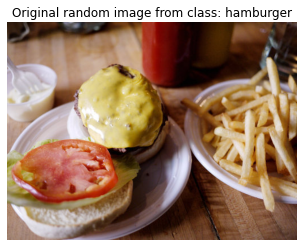

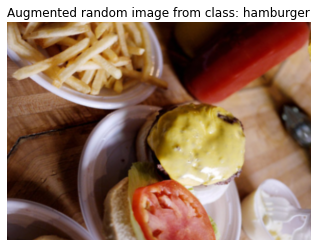

In [36]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class=random.choice(train_data_1_percent.class_names)
target_dir="10_food_classes_1_percent/train/"+ target_class
random_image=random.choice(os.listdir(target_dir))
random_image_path=target_dir + "/" + random_image

#Read and plot in the random image
img=mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False);

#Now read and plot our augmented random image
augmented_img=data_augmentation(tf.expand_dims(img,axis=0), training=True)
plt.figure()
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);
plt.imshow(augmented_img[0].numpy().astype("int32"))



## Model 1: Feature extraction transfer learning on 1 percent of the data with data augmentation



In [37]:
# Setup the input shape and base model, freeze the basemodel layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False


#Create input layers
inputs=layers.Input(shape=input_shape,name="input_layer")

#Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

#Give base_model the inputs(after augmentation) and don't train it
x = base_model(x, training=False)

#Pool the output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs=layers.Dense(10, activation="softmax", name="output_layer")(x)

#Make a model using the inputs and outputs
model_1=keras.Model(inputs,outputs)

#Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

#Fit the model
history_1_percent=model_1.fit(train_data_1_percent,
                  epochs=5,
                  steps_per_epoch=len(train_data_1_percent),
                  validation_data=test_data,
                  validation_steps=int(0.25* len(test_data)),
                  callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                         experiment_name="1_percent_data_aug")])




Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220317-142627
Epoch 1/5
3/3 [==============================] - 52s 22s/step - loss: 2.4403 - accuracy: 0.0429 - val_loss: 2.2510 - val_accuracy: 0.1678
Epoch 2/5
3/3 [==============================] - 44s 21s/step - loss: 2.1341 - accuracy: 0.2571 - val_loss: 2.1182 - val_accuracy: 0.2516
Epoch 3/5
3/3 [==============================] - 31s 15s/step - loss: 1.9633 - accuracy: 0.4000 - val_loss: 2.0231 - val_accuracy: 0.3339
Epoch 4/5
3/3 [==============================] - 44s 21s/step - loss: 1.8315 - accuracy: 0.4571 - val_loss: 1.9202 - val_accuracy: 0.3914
Epoch 5/5
3/3 [==============================] - 31s 14s/step - loss: 1.6325 - accuracy: 0.6429 - val_loss: 1.8289 - val_accuracy: 0.4375


In [38]:
# Check out our model summary
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [39]:
#Evaluate on the full test dataset
results_1_percent_data_aug=model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 110s 1s/step - loss: 1.8275 - accuracy: 0.4508


[1.827468752861023, 0.45080000162124634]

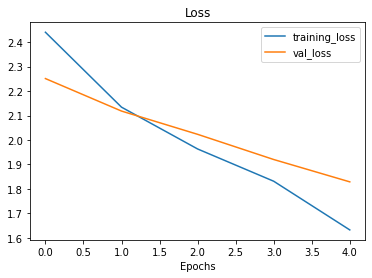

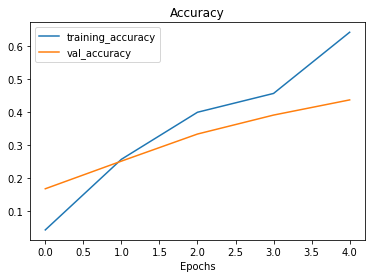

In [40]:
# How do the loss curves look like? (for 1 percent of data augmented)
plot_loss_curves(history_1_percent)

## Model 2: Feature extraction transfer learning with 10% of data and data augmentation



In [41]:
# Get 10% of the data of the 10 classes (uncomment if you haven't gotten "10_food_classes_10_percent.zip" already)
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
# unzip_data("10_food_classes_10_percent.zip")

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [42]:
# Set data inputs
import tensorflow
IMG_SIZE=(224,224)
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE)
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode="categorical",
                                                              image_size=IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [43]:
# Create model 2 witj data augmentation built in

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

#Build data augmentation layer
data_augmentation=Sequential([
     layers.RandomFlip("horizontal"),
     layers.RandomHeight(0.2),
     layers.RandomWidth(0.2),
     layers.RandomZoom(0.2),
     layers.RandomRotation(0.2),
     #layers.Rescaling(1./255) # Used in Resnet50v2, efficientmet has rescaling built in
     ], name="data_augmentation")

#Setup the input shape to our model
input_shape=(224,224,3)

#Create a frozen base model (also called the backbone)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create the inputs and outputs (including the layers in between)
inputs=layers.Input(shape=input_shape, name="input_layer")
x=data_augmentation(inputs) #Augments our training images
x=base_model(x, training=False)# Pass augmented images to base model but keep the base model in inference mode, this also insures batchnorm layers don't get updated
x=layers.GlobalAveragePooling2D(name="globale_avergae_pooling_2D")(x)
outputs=layers.Dense(10,activation="softmax",name="output_layer")(x)
model_2=tf.keras.Model(inputs,outputs)

#Compile
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

        

In [44]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 globale_avergae_pooling_2D   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermidiately saves our model(the full model or just the weights) during training. This is useful so we can come and start where we left off

In [45]:
# set checkpoint path
checkpoint_path="ten_percent_model_checkpoints_weights/checkpoint.ckpt"

#Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=False,
    save_freq="epoch", # Save after every epoch,
    verbose=1
)


### Fit model 2 passing in the ModelCheckpoint callback

In [46]:
# Fit the model saving checkpoints every epoch
initial_epochs=5
history_10_percent_model_2_data_aug=model_2.fit(
    train_data_10_percent,
    epochs=initial_epochs,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=int(0.25*len(test_data)),
    callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                           experiment_name="10_percent_data_aug"),
               checkpoint_callback])


Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220317-143533
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0197 - accuracy: 0.3320
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 90s 4s/step - loss: 2.0197 - accuracy: 0.3320 - val_loss: 1.5286 - val_accuracy: 0.6184
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3830 - accuracy: 0.6667
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 86s 4s/step - loss: 1.3830 - accuracy: 0.6667 - val_loss: 1.1088 - val_accuracy: 0.7582
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0759 - accuracy: 0.7413
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 87s 4s/step - loss: 1.0759 - accuracy: 0.7413 - val_loss: 0.8829 - val_accuracy: 0.7780
Epoch 4/5


In [47]:
#What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 131s 2s/step - loss: 0.5979 - accuracy: 0.8424


[0.5979278683662415, 0.8424000144004822]

In [48]:
# Check model_2 results on all test data
results_10_percent_data_aug=model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 134s 2s/step - loss: 0.6934 - accuracy: 0.8072


[0.6933813691139221, 0.807200014591217]

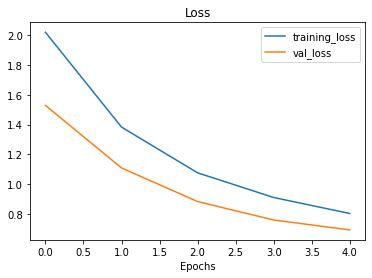

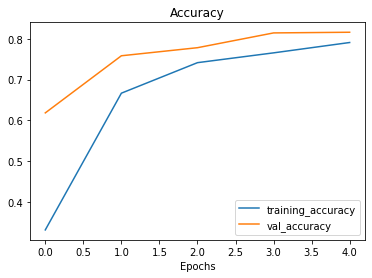

In [49]:
# Plot model loss curves
plot_loss_curves(history_10_percent_model_2_data_aug)

### Loading in checkpointed weights

Loading in checkpointedweights returns a model to a specific checkpoint


In [50]:
#Load in saved model weights and evaluate the model
model_2.load_weights(checkpoint_path)

In [51]:
#Evaluate model_2 with loaded weights
loaded_weights_model_results=model_2.evaluate(test_data)

79/79 [==============================] - 137s 2s/step - loss: 0.6934 - accuracy: 0.8072


In [52]:
#If the results of our previously evaluated model_2 match the loaded weights, everything has worked
results_10_percent_data_aug==loaded_weights_model_results

False

In [53]:
loaded_weights_model_results


[0.6933810114860535, 0.807200014591217]

In [54]:
results_10_percent_data_aug


[0.6933813691139221, 0.807200014591217]

In [55]:
# Check to see if loaded model results are very close to our previouls non-loaded model
import numpy as np
np.isclose(np.array(results_10_percent_data_aug),np.array(loaded_weights_model_results))

array([ True,  True])

In [56]:
#Check the difference between the two results
print(np.array(results_10_percent_data_aug)-np.array(loaded_weights_model_results))

[3.57627869e-07 0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10% of the data

> **Note:** Fine-tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data


In [57]:
# Layers in loaded model
model_2.layers

In [58]:
#Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f1e11943c10> True
<keras.engine.sequential.Sequential object at 0x7f1e11943410> True
<keras.engine.functional.Functional object at 0x7f1e0760d5d0> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f1e07b11590> True
<keras.layers.core.dense.Dense object at 0x7f1e076a4a90> True


In [59]:
# What layers are in our base model (EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i,layer.name,layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [60]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [61]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

**Note:** Lower the learning rate when fine tuning so as to not change the patterns too much. Lower by 10x(can be changed)

In [62]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [63]:
print(len(model_2.layers[2].trainable_variables))

10


In [64]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               validation_data=test_data,
                                               initial_epoch=history_10_percent_model_2_data_aug.epoch[-1], # start from previous last epoch
                                               validation_steps=int(0.25 * len(test_data)),
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately


Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220317-145325
Epoch 5/10
24/24 [==============================] - 95s 4s/step - loss: 0.6720 - accuracy: 0.8107 - val_loss: 0.5646 - val_accuracy: 0.8158
Epoch 6/10
24/24 [==============================] - 80s 3s/step - loss: 0.5940 - accuracy: 0.8227 - val_loss: 0.5072 - val_accuracy: 0.8405
Epoch 7/10
24/24 [==============================] - 88s 4s/step - loss: 0.4757 - accuracy: 0.8507 - val_loss: 0.4888 - val_accuracy: 0.8355
Epoch 8/10
24/24 [==============================] - 87s 4s/step - loss: 0.4488 - accuracy: 0.8693 - val_loss: 0.4689 - val_accuracy: 0.8388
Epoch 9/10
24/24 [==============================] - 85s 4s/step - loss: 0.4177 - accuracy: 0.8773 - val_loss: 0.4574 - val_accuracy: 0.8470
Epoch 10/10
24/24 [==============================] - 85s 4s/step - loss: 0.3727 - accuracy: 0.8853 - val_loss: 0.4786 - val_accuracy: 0.8322


In [65]:
#Evaluate the fine-tuned model (model_3 which is actually model_2 fine tuned for another 5 epochs)
results_fine_tune_10_percent=model_2.evaluate(test_data)

79/79 [==============================] - 135s 2s/step - loss: 0.4825 - accuracy: 0.8360


In [66]:
results_10_percent_data_aug

[0.6933813691139221, 0.807200014591217]

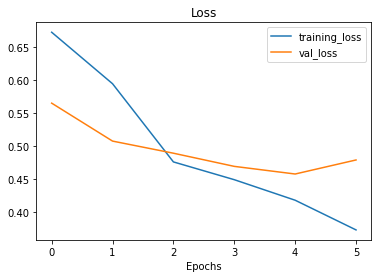

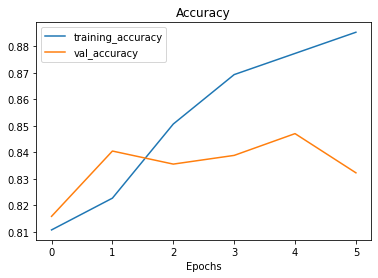

In [67]:
#Check out the loss curves of our fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (i.e. before and after fine-tuning)

In [68]:
#Let's creat a function to compare training histories
def compare_histories(original_history,new_history,initial_epochs=5):
  """

  Compares tow TnesorFlow History objects
  """

  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  print(len(acc))

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history with new history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  print(len(total_acc))
  print(total_acc)

  # Make plots for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  #Make plots for loss

  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Validation Loss')
  plt.plot([initial_epochs-1, initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()
  

5
11
[0.3319999873638153, 0.6666666865348816, 0.7413333058357239, 0.765333354473114, 0.7906666398048401, 0.8106666803359985, 0.8226666450500488, 0.8506666421890259, 0.8693333268165588, 0.8773333430290222, 0.8853333592414856]


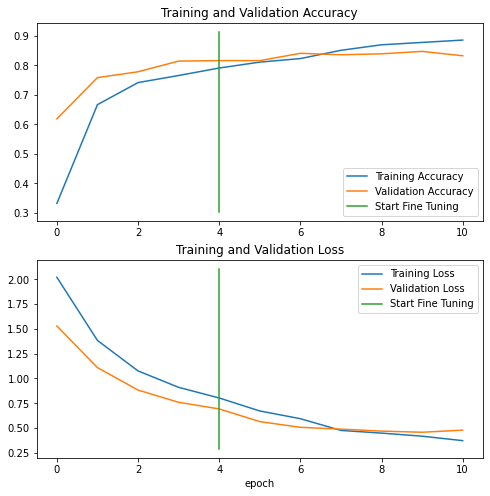

In [69]:
compare_histories(history_10_percent_model_2_data_aug,
                  history_fine_10_percent_data_aug,
                  initial_epochs=5)

## Model 4: Fine-tuning an existing model on all of the data


In [70]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip 
unzip_data("10_food_classes_all_data.zip")

--2022-03-17 15:07:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.253.122.128, 142.250.81.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   182MB/s    in 2.7s    

2022-03-17 15:08:01 (182 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [71]:
#Set up training and test directories
train_dir_all_data="10_food_classes_all_data/train"
test_dir="10_food_classes_all_data/test"

In [72]:
#How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 

In [73]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
train_data_10_classes_full=tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                               label_mode="categorical",
                                                                               image_size=IMG_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode="categorical",
                                                               image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments(all experiments have used the same test dataset)

Let's verify this...

In [74]:
# Evaluate model 2(this is the fine-tuned on 10 percent of data verison)
model_2.evaluate(test_data)

79/79 [==============================] - 142s 2s/step - loss: 0.4825 - accuracy: 0.8360


[0.4825010597705841, 0.8360000252723694]

In [75]:
results_fine_tune_10_percent

[0.48250094056129456, 0.8360000252723694]

To train a fine-tuning model (model_4) we need to revert model 2 back to its feature extraction weights

In [76]:
# Load weights from checkpoint, that way we can fine-tune from the same stage the 10 percent data modelwas fine-tuned from
model_2.load_weights(checkpoint_path)

In [77]:
#Let's evaluate model_2 now
model_2.evaluate(test_data)

79/79 [==============================] - 146s 2s/step - loss: 0.6934 - accuracy: 0.8072


[0.6933810114860535, 0.807200014591217]

In [78]:
# Check to see if our model_2 has been reverted back to feature extraction results
results_10_percent_data_aug

[0.6933813691139221, 0.807200014591217]

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using ModelCheckpoint.
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen.
3. Saved the results and training logs each time.
4. Reloaded the model from 1 to do the same steps as 2 but with all of the data.

The same steps as 2?

Yeah, we're going to fine-tune the last 10 layers of the base model with the full dataset for another 5 epochs but first let's remind ourselves which layers are trainable.

In [79]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [80]:
#Check which layers are tunable in the whole model
for layer_number,layer in enumerate(model_2.layers):
  print(layer_number,layer.name,layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 globale_avergae_pooling_2D True
4 output_layer True


In [81]:
# Check which layers are tuneable in the base model
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [82]:
# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])



In [ ]:
# Fit the data to fine-tune our data (100% of training data)
fine_tune_epochs=initial_epochs+5

history_fine_10_classes_full=model_2.fit(train_data_10_classes_full,
                                         epochs=fine_tune_epochs,
                                         validation_data=test_data,
                                         validation_steps=int(0.25*len(test_data)),
                                         initial_epoch=history_10_percent_model_2_data_aug.epoch[-1],
                                         callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                                experiment_name="full_10_classes_fine_tune_last_10")])


In [ ]:
# Let's evaluate on all the test data
results_fine_tune_full_data=model_2.evaluate(test_data)
results_fine_tune_full_data

In [ ]:
#How did fine-tuning go with more data?
compare_histories(original_history=history_10_percent_data_aug,
                new_history=history_fine_10_classes_full,
                initial_epochs=5)

## Viewing our experiment data on TensorBoard

>Anything uploaded to TensorBoard.dev is going to be public.


In [ ]:
# View tensorboard logs of transfer learning modeeling experiments (5 models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
    --name "Transfer Learning Experiments with 10 Food101 classes" \
    --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
    --one_shot #exits the uploader once it's finished uploading

MyTensorBoard experiments are available at: 

In [ ]:
!tensorboard dev list

In [ ]:
# To delete an experiment
#!tensorboard dev delete --experiment_id (put id)